### Dependencies
* https://gist.githubusercontent.com/sixtenbe/1178136/raw/deb306a4ff697d33a4d069d59a6706ccd2be7f83/peakdetect.py  (download and put in the notebook folder)

In [220]:
%matplotlib inline
import csv
import json
import time
import sys
from concurrent.futures import ThreadPoolExecutor

import requests
import mwapi
import mwtypes
import pandas
import seaborn

In [221]:
session = mwapi.Session("https://en.wikipedia.org", user_agent="ahalfaker@wikimedia.org -- IWSC demo")

In [222]:
WEIGHTS = {'Stub': 1, 'Start': 2, 'C': 3, 'B': 4, 'GA': 5, 'FA': 6}
def score2sum(score_doc):
    if score_doc is None:
        return None
    weighted_sum = 0
    for cl, proba in score_doc['probability'].items():
        weighted_sum += WEIGHTS[cl] * proba
    return weighted_sum

In [223]:
def fetch_wp10_score(rev_id):
    response = requests.get('https://ores.wikimedia.org/v3/scores/enwiki/{0}/wp10'.format(rev_id))
    try:
        return response.json()['enwiki']['scores'][str(rev_id)]['wp10']['score']
    except:
        return None


def fetch_wp10_scores(rev_ids):
    executor = ThreadPoolExecutor(max_workers=8)
    return executor.map(fetch_wp10_score, rev_ids)

def fetch_historical_scores(page_name):
    historical_scores = []
    for response_doc in session.get(action='query', prop='revisions', titles=page_name, 
                                    rvprop=['ids', 'timestamp','user'], rvlimit=100, rvdir="newer", 
                                    formatversion=2, continuation=True):
        rev_docs = response_doc['query']['pages'][0]['revisions']
        rev_ids = [d['revid'] for d in rev_docs]
        for rev_doc, score_doc in zip(rev_docs, fetch_wp10_scores(rev_ids)):
            rev_id = rev_doc['revid']
            user = rev_doc['user']
            timestamp = mwtypes.Timestamp(rev_doc['timestamp'])
            weighted_sum = score2sum(score_doc)
            historical_scores.append({'rev_id': rev_id, 'timestamp': timestamp, 'weighted_sum': weighted_sum,'user':user})
            sys.stderr.write(".")
            sys.stderr.flush()
        sys.stderr.write("\n")
    
    return historical_scores


In [224]:
def oresToPandas(title):
    historical_scores = pandas.DataFrame(fetch_historical_scores(title))
    historical_scores['time'] =pandas.to_datetime(historical_scores.timestamp, format='%Y-%m-%dT%H:%M:%SZ',errors='ignore')
    historical_scores = historical_scores.set_index('time')
    return historical_scores

In [225]:
data=oresToPandas('Ada Lovelace')

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................................

In [235]:
from peakdetect import peakdetect
from collections import Counter
def plotAndPeaks(df):
    indexes = peakdetect(df.weighted_sum, lookahead=1,delta=1)
    print('Max')
    for i in indexes[0]:
        print(df.index[i[0]],'https://en.wikipedia.org/w/?diff=prev&oldid=%s' % df.rev_id[i[0]],df.user[i[0]])
    print('Min')
    for i in indexes[1]:
        print(df.index[i[0]],'https://en.wikipedia.org/w/?diff=prev&oldid=%s' % df.rev_id[i[0]],df.user[i[0]],df.weighted_sum[i[0]])
    return df['weighted_sum'].plot()

def vandalCandidates(df):
    vandals = []
    indexes = peakdetect(df.weighted_sum, lookahead=1, delta=1)
    for i in indexes[1]:
        vandals.append(df.user[i[0]])
        #print(df.index[i[0]],'https://en.wikipedia.org/w/?diff=prev&oldid=%s' % df.rev_id[i[0]],df.user[i[0]])
    candidates = [x for x,y in Counter(vandals).most_common(5)]
    for i in indexes[1]:
        if df.user[i[0]] in candidates:
            #print(df.index[i[0]-1],'https://en.wikipedia.org/w/?diff=prev&oldid=%s' % df.rev_id[i[0]],df.user[i[0]])
            pass
    print(candidates)
    return None
 
    
    


Max
2005-08-26 20:05:17 https://en.wikipedia.org/w/?diff=prev&oldid=21905286 Nomalam
2005-12-10 12:21:50 https://en.wikipedia.org/w/?diff=prev&oldid=30816572 85.157.99.138
2005-12-13 14:32:26 https://en.wikipedia.org/w/?diff=prev&oldid=31192184 Hu
2006-02-24 15:30:32 https://en.wikipedia.org/w/?diff=prev&oldid=41023078 Misza13
2006-05-21 12:40:04 https://en.wikipedia.org/w/?diff=prev&oldid=54345388 Craigy144
2006-09-07 09:30:06 https://en.wikipedia.org/w/?diff=prev&oldid=74303744 Glen
2006-10-12 23:26:32 https://en.wikipedia.org/w/?diff=prev&oldid=81106220 63.101.39.6
2006-11-02 05:54:45 https://en.wikipedia.org/w/?diff=prev&oldid=85203776 24.84.204.9
2007-01-31 22:06:00 https://en.wikipedia.org/w/?diff=prev&oldid=104685653 82.55.80.46
2007-03-06 18:55:11 https://en.wikipedia.org/w/?diff=prev&oldid=113118512 216.20.110.226
2007-09-29 04:17:12 https://en.wikipedia.org/w/?diff=prev&oldid=161055437 Ihope127
2008-04-04 02:23:20 https://en.wikipedia.org/w/?diff=prev&oldid=203199546 99.163.1

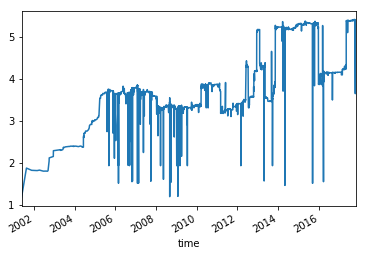

In [236]:
plotAndPeaks(data)

In [237]:
vandalCandidates(data)


['168.9.44.2', '70.89.137.17', '198.111.152.212', '194.83.69.174', '203.189.4.17']
